In [1]:
import warnings
warnings.filterwarnings("ignore")
import glob
import torch
import time
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image
from IPython.display import clear_output

In [2]:
import plotly
from plotly.offline import iplot
import plotly.graph_objs as go

In [3]:
plotly.offline.init_notebook_mode(connected=True)

In [4]:
import sys
sys.path.append("../pyfiles/")
from util import * 
from dataset import * 
from model import * 

# Get celebA dataset

In [5]:
label_discription = [
    "male, smiling",
    "male, not smiling",
    "female, smiling",
    "female, not smiling"
]

In [6]:
root = "./../../dataset/celebA/img/"
label_root = "./../../dataset/celebA/label_folder/"

In [7]:
# 1 5 o clock shadow
# 11 blurry
# 14 chubby
# 15 double chin
# 16 eyeglasses
# 17 goatee
# 21 male
# 23 mustache
# 25 No_Beard
# 31 sideburns
# 32 smiling
# 36 wearing hat
# 40 young
dataset_label = {}
dataset_label["existed"] = [25] 
dataset_label["delete"] = [1, 11, 14, 15, 16, 17, 23, 31, 36] 
dataset_label["class"] = [21, 32] 

In [8]:
classes = tuple(range(2**len(dataset_label["class"])))
cl = get_class_label(len(dataset_label["class"]))
classes

(0, 1, 2, 3)

In [9]:
normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])

class MinMax(object):
    def __init__(self, mean0=True):
        self.mean0 = mean0
        pass
    def __call__(self, img):
        return torch.Tensor(min_max(cuda2numpy(img), mean0=self.mean0))
    def __repr__(self):
        return self.__class__.__name__

transform = {}
transform["train"] = transforms.Compose([
    transforms.CenterCrop((178, 178)),
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    MinMax(True),
])
    
transform["test"] = transforms.Compose([
    transforms.CenterCrop((178, 178)),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    MinMax(True),
#     normalize,
])

In [10]:
each_train_num = 10000000
each_val_num = 0
each_test_num = 100
dataset = FaceDataset(root, label_root, transform["train"], dataset_label, classes, data_type="train", train_num=each_train_num, val_num=each_val_num, test_num=each_test_num)
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=256, shuffle=True)
testset = FaceDataset(root, label_root, transform["test"], dataset_label, classes, data_type="test", train_num=each_train_num, val_num=each_val_num, test_num=each_test_num)
len(dataset), len(testset)

(134530, 400)

0


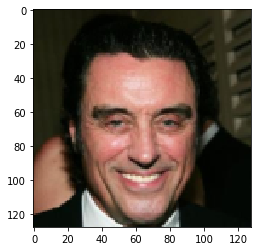

In [11]:
data = dataloader.dataset[24]
img = data[0]
image = image_from_output(torch.reshape(img, (1,img.shape[0],img.shape[1],img.shape[2])))[0]
print(data[1])
plt.imshow(image)

## Algorithm

In [12]:
def shuffle(img):
    return img[np.random.choice(np.arange(img.shape[0]), size=img.shape[0], replace=False)]

In [13]:
class SRGAN_training():
    def __init__(self, net, opt, criterion, lbd, unrolled_k, device, ref_label,
                 batch_size=64, encoded_feature="latent", styleINdataset=True, ndim=8):
        self.G, self.D, self.E = net[0].to(device), net[1].to(device), net[2].to(device)
        self.optG, self.optD, self.optE = opt[0], opt[1], opt[2]
        self.scheG, self.scheD, self.scheE = None, None, None
        self.criterion, self.criterion_class = criterion
        self.lbd = lbd
        self.k = unrolled_k
        self.device = device
        self.ref_label = ref_label
        self.n_batch = batch_size
        self.encoded_feature = encoded_feature
        self.styleINdataset = styleINdataset
        self.ndim = ndim
        self.source_image = None
        self.target_image = None
        self.recon_image = None
        self.label = None
        self.c_rand = None
        self.enc_info = None
        self.target_cenc = None
        if lbd["hist"]>0:
            self.hi = histogram_imitation(device)
    
    def opt_sche_initialization(self, lr=[0.0001, 0.0001, 0.0001]):
        lr_G, lr_D, lr_E = lr
        if self.optG==None:
            self.optG = optim.Adam(self.G.parameters(), lr=lr_G, betas=(0.5, 0.999))
        self.scheG = optim.lr_scheduler.ExponentialLR(self.optG, gamma=0.95)
        if self.optD==None:
            self.optD = optim.Adam(self.D.parameters(), lr=lr_D, betas=(0.5, 0.999))
        self.scheD = optim.lr_scheduler.ExponentialLR(self.optD, gamma=0.95)
        if self.optE==None:
            self.optE = optim.Adam(self.E.parameters(), lr=lr_E, betas=(0.5, 0.999))
        self.scheE = optim.lr_scheduler.ExponentialLR(self.optE, gamma=0.95)
        return
        
    def G_transformation(self, target_label, source_image, encoder=False, ref_image=None):
        if encoder:
            latent, mu, logvar, class_output, attention = self.E(ref_image)
            info = [latent, mu, logvar, class_output, attention]
            if self.encoded_feature == "latent":
                latent_vector = latent
            elif self.encoded_feature == "mu":
                latent_vector = mu
                
        else:
            latent_vector = torch.randn(source_image.shape[0], self.ndim).to(self.device)
            info = latent_vector
            
        class_vector = class_encode(target_label, self.device, self.ref_label)
        class_vector = torch.cat([class_vector, latent_vector], 1)
        target_image = self.G(source_image, class_vector)
        
        return target_image, info
        
    def update_D(self):
        self.D.zero_grad()
        if self.styleINdataset:
#             c, random = self.label["index"]
#             self.target_image, [_,self.c_rand,_,_,_] = self.G_transformation(self.label["target"], self.source_image, True, self.source_image[c][random])
            self.target_image, [_,self.c_rand,_,_,_] = self.G_transformation(self.label["target"], self.source_image, True, shuffle(self.source_image))
        else:
            self.target_image, self.c_rand = self.G_transformation(self.label["target"], self.source_image, False)
        
        errD = 0
        # real image
        output, output_class = self.D(self.source_image)
        errD_real = get_loss_D(output, 1., self.criterion, self.device)
        errD_class = get_domainloss_D(output_class, class_encode(self.label["source"], self.device, self.ref_label), self.criterion_class)
        errD += errD_real + errD_class*self.lbd["class"]

        # fake image
        output, output_class = self.D(self.target_image.detach())
        errD_fake = get_loss_D(output, 0., self.criterion, self.device)
        errD += errD_fake

        # gradient penalty
        if self.lbd["gp"] > 0:
            errD_gp = get_gradient_penalty(self.D, self.source_image, self.target_image.detach())
            errD += errD_gp * self.lbd["gp"]
            
        errD.backward()
        self.optD.step()
        return errD
    
    def update_GandE(self):
        self.G.zero_grad()
        self.E.zero_grad()

        errG = 0
        errE = 0
        errE_output = 0

        ## ordinary SingleGAN loss
        recon_image, source_enc_info = self.G_transformation(self.label["source"], self.target_image, True, self.source_image)
        output, output_class = self.D(self.target_image)
        errG_dis = get_loss_D(output, 1., self.criterion, self.device)
        errG_class = get_domainloss_D(output_class, class_encode(self.label["target"], self.device, self.ref_label), self.criterion_class)
        errG_cycle = torch.mean(torch.abs(self.source_image - recon_image))
        errG += errG_dis + errG_class*self.lbd["class"] + errG_cycle*self.lbd["cycle"]
        errE_output += errG_cycle * self.lbd["cycle"]
        
        ## multimodal transformation (KL): Conventional KL
        if self.lbd["KL"] > 0:
            _, mu, logvar, _, _ = source_enc_info
            errE_KL = -0.5 * torch.sum(1 + logvar - mu**2 - logvar.exp_()) 
            errE += errE_KL*self.lbd["KL"]
            errE_output += errE_KL*self.lbd["KL"]
            
        ## Identity loss under source style condition
        if self.lbd["idt"] > 0:
            identity_image, _ = self.G_transformation(self.label["source"], self.source_image, True, self.source_image)
            errG_idt = torch.mean(torch.abs(self.source_image - identity_image))
            errG += errG_idt*self.lbd["idt"]
            errE_output += errG_idt*self.lbd["idt"]
            
        ## encoder attention loss
        if self.lbd["attention"] > 0:
            _, _, _, _, attention = source_enc_info
            errE_att = get_focus_loss(attention, lbd=1)
            errE += errE_att*self.lbd["attention"]
            errE_output += errE_att*self.lbd["attention"]
        
        ## encoder classification loss
        if self.lbd["class_enc"] > 0:
            _, _, _, output_class_enc, _ = source_enc_info
            errE_class_enc = get_domainloss_D([output_class_enc], class_encode(self.label["source"], self.device, self.ref_label), self.criterion_class)
            errE += errE_class_enc*self.lbd["class_enc"]
            errE_output += errE_class_enc*self.lbd["class_enc"]
            
        ## batch size KL
        if self.lbd["batch_KL"] > 0:
            _, mu, _, _, _ = source_enc_info
            var = torch.var(mu, dim=0)*self.n_batch/(self.n_batch-1)
            mean = torch.mean(mu, dim=0)
            errE_bKL = -0.5 * torch.sum(1 + torch.log(var) - mean**2 - var) 
            errE += errE_bKL*self.lbd["batch_KL"]
            errE_output += errE_bKL*self.lbd["batch_KL"]
            
        ## correlative loss
            if self.lbd["corr_enc"] > 0:
                errE_corr = corrcoef_loss(mu.T, self.device)
                errE += errE_corr*self.lbd["corr_enc"]
                errE_output += errE_corr*self.lbd["corr_enc"]
                
        ## histgram imitation loss
            if self.lbd["hist"] > 0:
                errE_hist = self.hi.loss(mu)
                errE += errE_hist*self.lbd["hist"]
                errE_output += errE_hist*self.lbd["hist"]
                
        ## Consistency Regularization
        if self.lbd["consis_reg"] > 0:
            augmented = get_augmented_image(self.source_image, augment)
            _, augmented_mu, _, _, _ = self.E(augmented)
            _, source_mu, _, _, _ = source_enc_info
            
            errE_consis_reg = torch.mean(torch.abs(augmented_mu - source_mu)*2)
            errE += errE_consis_reg*self.lbd["consis_reg"]
            errE_output += errE_consis_reg*self.lbd["consis_reg"]
        
        errG.backward(retain_graph=True)
        errE.backward(retain_graph=True)
        self.optG.step()
        self.optE.step()
        
        ########################### update exclusively G ###########################
        self.G.zero_grad()
        self.E.zero_grad()
        
        errG_ex = 0
        ## multimodal transformation (regression loss)
        _, target_cenc, _, _, _ = self.E(self.target_image)
        errG_reg = torch.mean(torch.abs(self.c_rand - target_cenc))
        errG_ex += errG_reg * self.lbd["reg"]
        
        ## multimodal transformation (regression loss for identity images)
        if self.lbd["idt_reg"]*self.lbd["idt"] > 0:
            errG_idt_reg = 0
            
            ## random condition
            idt_random_image, [_,source_c_rand,_,_,_] = self.G_transformation(self.label["source"], self.source_image, True, self.source_image)
            _, idt_cenc_rand, _, _, _ = self.E(idt_random_image)
            errG_idt_reg += torch.mean(torch.abs(source_c_rand - idt_cenc_rand))
            errG_ex += errG_idt_reg * self.lbd["idt_reg"] * (self.lbd["idt"]/self.lbd["cycle"])
            
        errG_ex.backward()
        self.optG.step()
        
        errG += errG_ex
        
        return [errG, errE_output]
    
    def UnrolledUpdate(self):
        for i in range(self.k):

            # update D
            errD = self.update_D()
            if i==0:
                paramD = self.D.state_dict()
                errorD = errD

        # update G
        errorG, errorE = self.update_GandE()

        self.D.load_state_dict(paramD)
        return [errorG, errorD, errorE]
        
    def train(self, source_image, label):
        self.source_image = source_image
        self.label = label
        error = self.UnrolledUpdate()
        return error

# conditional GAN

In [14]:
epoch_num = 31
lr_D = 0.0001
lr_G = 0.0002
lr_E = 0.001
# torch.cuda.set_device("cuda:4")
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [15]:
import pandas as pd
def get_adjustable_parameters(notebook_no=1):
    if notebook_no == 3: 
        models = [["conventionalKL", False],
                  ["conventionalKL", True],
                  ["proposedKL", False],
                  ["proposedKL", True]]
        columns=["restriction_type", "styleINdataset"]
        
    if notebook_no == 5:
        models = [["pretrained", "", ""],
                  ["gradattention", "relu", ""],
                  ["gradattention", "relumodified", 0.1],
                  ["gradattention", "relumodified", 1],
                  ["gradattention", "relumodified", 10],
                  ["gradattention", "relumodified", 100],
                  ["gradattention", "relumodified", 1000]]
        columns = ["model_type", "attention_mode", "attention"]
    return pd.DataFrame(np.array(models), columns=columns)
get_adjustable_parameters(5)

model_type attention_mode attention
0     pretrained                         
1  gradattention           relu          
2  gradattention   relumodified       0.1
3  gradattention   relumodified         1
4  gradattention   relumodified        10
5  gradattention   relumodified       100
6  gradattention   relumodified      1000

In [16]:
# ---- adjustable parameters ---- #
ndim = 8 # the dimension of noise vector, indicating the style
nch_in = 3
nch = 64
reduce = 2
num_cls = 2
res_num = 6
dis_reduce = 2
dis_nch = 64
dis_num_cls = 4

model_type = "pretrained" # "nopretraining", "gradattention", "pretrained"
attention_mode = "" # this will be available when you set 'model_type' as "gradattention": "relu", "relumodified"
restriction_type = "proposedKL" # "conventionalKL", "proposedKL"
styleINdataset = True
save_parameter = True
###################################

ref_label = np.eye(len(classes))
if restriction_type == "conventionalKL":
    encoded_feature = "latent" # "latent" or "mu"
elif restriction_type == "proposedKL":
    encoded_feature = "mu" # "latent" or "mu"
if styleINdataset:
    styleINdataset_or_not = "styleINdataset_"
else:
    styleINdataset_or_not = ""
hi = histogram_imitation(device)

In [17]:
criterion = nn.MSELoss()
criterion_class = nn.MSELoss()

In [18]:
devices = [0,1,2,3]
netG = SingleGenerator(nch_in, nch, reduce, num_cls, res_num, "instance", num_con=ref_label.shape[1]+ndim).to(device)
netG.apply(weights_init)
netG = nn.DataParallel(netG, devices)
netD = SingleDiscriminator_solo_multi(nch_in, dis_nch, dis_reduce, dis_num_cls, "instance", ref_label.shape[1]).to(device)
netD.apply(weights_init)
netD = nn.DataParallel(netD, devices)
if model_type in ["nopretraining", "pretrained"]:
    netE = Encoder(nch_in, ndim, nch, 4, "instance", ref_label.shape[1]).to(device)
elif model_type=="gradattention":
    netE = Encoder_gradattention(nch_in, ndim, nch, 4, "instance", ref_label.shape[1], attention_mode, classes, criterion_class, device, ref_label).to(device)
netE.apply(weights_init);

In [19]:
if model_type in ["gradattention", "pretrained"]:
    dir = "../data/parameters/04/"
    dir = "instant_model_parameter/"
    model_path = f"{dir}facial_recognizer_encoder_lr0.0001_epoch228.pth"
    netE = load_classifier(netE, model_path)
    classifier = Encoder_classifier(nch_in, ndim, nch, 4, "instance", ref_label.shape[1]).to(device)
    classifier_layers = list(classifier.state_dict().keys())
    netE.freeze_melt(classifier_layers, "freeze")
    optE = optim.Adam(filter(lambda p: p.requires_grad, netE.parameters()), lr=0.001, betas=(0.5, 0.999))
    netE.freeze_melt(classifier_layers, "melt");
else:
    optE = None
netE = nn.DataParallel(netE, devices)

_IncompatibleKeys(missing_keys=['fcmean.weight', 'fcmean.bias', 'fcvar.weight', 'fcvar.bias', 'fcclass_reduced.weight', 'fcclass_reduced.bias'], unexpected_keys=[])


## train

In [20]:
lbd = {}
lbd["class"] = 1
lbd["cycle"] = 5
lbd["idt"] = 5
lbd["reg"] = 0.5
lbd["idt_reg"] = 0.5
lbd["gp"] = 0
lbd["consis_reg"] = 0

if restriction_type == "conventionalKL":
    lbd["KL"] = 0.1
    lbd["batch_KL"] = 0
    lbd["corr_enc"] = 0
    lbd["hist"] = 0
elif restriction_type == "proposedKL":
    lbd["KL"] = 0
    lbd["batch_KL"] = 10
    lbd["corr_enc"] = 100
    lbd["hist"] = 100
    
if (model_type=="gradattention") and (attention_mode=="relumodified"):
    lbd["class_enc"] = 10
    lbd["attention"] = 10000
else:
    lbd["class_enc"] = 0
    lbd["attention"] = 0

unrolled_k = 5

In [21]:
each_train_num = 10000
batch_size = 128
dataset = FaceDataset(root, label_root, transform["train"], dataset_label, classes, data_type="train", train_num=each_train_num, val_num=0, test_num=100)
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
testset = FaceDataset(root, label_root, transform["test"], dataset_label, classes, data_type="test", train_num=each_train_num, val_num=0, test_num=10)
sampleset = FaceDataset(root, label_root, transform["test"], dataset_label, classes, data_type="test", train_num=each_train_num, val_num=0, test_num=16)
len(dataset), len(testset)

(40000, 40)

In [22]:
sg = SRGAN_training([netG, netD, netE], [None, None, optE], [criterion, criterion_class], 
                       lbd, unrolled_k, device, ref_label, batch_size, encoded_feature, styleINdataset, ndim)
sg.opt_sche_initialization()

9: 22.820620640118918 mins


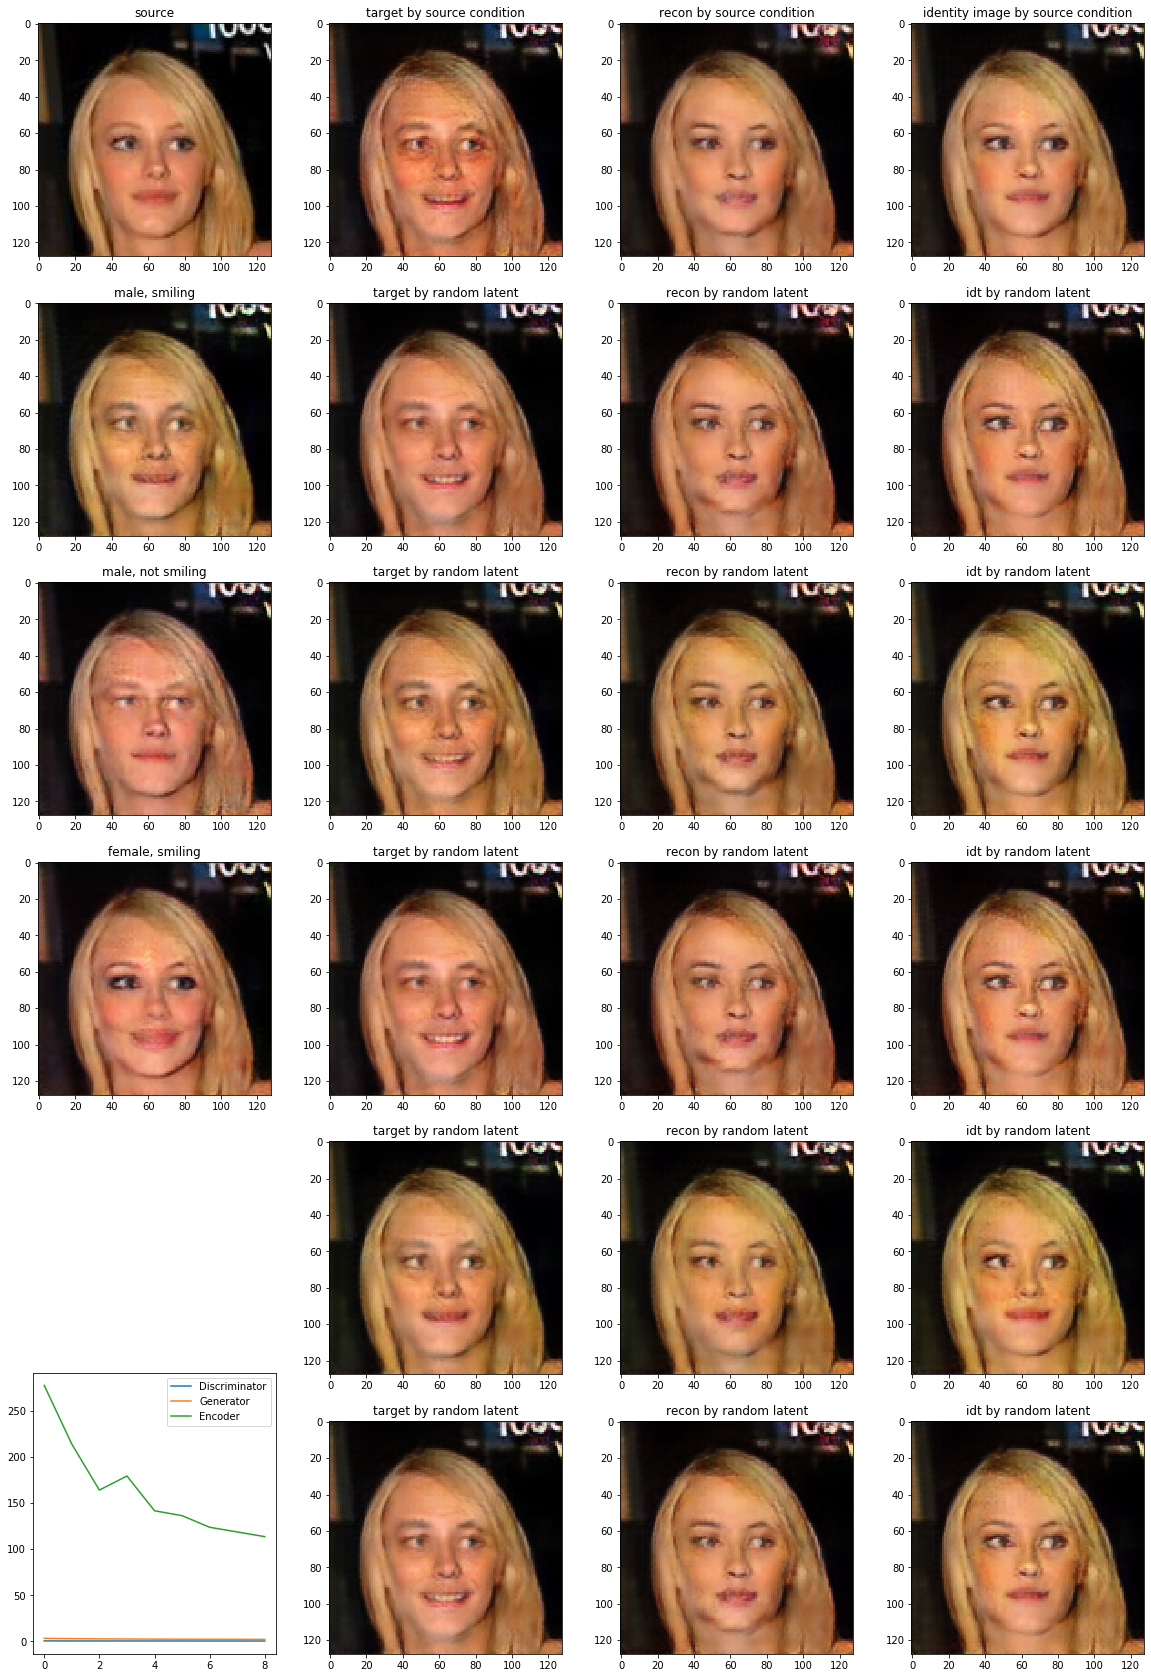

In [ ]:
run_train = True
if run_train:
    interval = int(len(dataset)/batch_size/3) + 2
    losses_D = []
    losses_G = []
    losses_E = []
    for epoch in range(epoch_num):
        start_time = time.time()
        loss_D = []
        loss_G = []
        loss_E = []
        for itr, data in enumerate(dataloader):
            netG.train()
            data_image = data[0]
            data_label = data[1]

            source_image = data_image.to(device)
            label = {}

            label["source"] = data_label.to(device)
            whole_target = get_target(data_label, classes, whole=False)
            label["target"] = torch.tensor(whole_target[:,0], dtype=torch.long, device="cpu")

#             if styleINdataset:
#                 a = np.argsort(np.array(data_label))
#                 a_ = np.array(data_label)[a]
#                 b = list(a_)
#                 num = np.random.randint(1, len(classes))
#                 c = list(a)[b.index(num):] + list(a)[:b.index(num)]
#                 d = np.argsort(np.array(data_label))
#                 random = np.argsort(d)
#                 label["index"] = c, random
#                 label["target"] = data_label[c][random]
#             else:
#                 label["target"] = torch.tensor(whole_target[:,0], dtype=torch.long, device="cpu")

            errG, errD, errE = sg.train(source_image, label)

            if type(errD)!=int:
                errD = errD.detach().to("cpu").numpy()
                loss_D.append(errD)
            if type(errG)!=int:
                errG = errG.detach().to("cpu").numpy()
                loss_G.append(errG)
            if type(errE)!=int:
                errE = errE.detach().to("cpu").numpy()
                loss_E.append(errE)

            if itr%interval==0:
                if not itr==0:
                    clear_output(wait=True)
                    print(f"epoch {epoch} :itr {itr}/{int(len(dataset)/batch_size)}: {(time.time()-start_time)/60} mins")
                    fig = get_output_and_plot(sg, sampleset, 53, [classes, label_discription], 5, styleINdataset, device)

                    if not epoch==0:
                        length = 5
                        width = 4
                        losses = [losses_D, losses_G, losses_E]
                        ax = fig.add_subplot(length, width, 17)
                        models = ["Discriminator", "Generator", "Encoder"]
                        for k in range(len(losses)):
                            if models[k] == "Discriminator":
                                if type(losses[k]) == dict:
                                    for i in classes:
                                        ax.plot(losses[k][i], label=f"Discriminator-{i}")
                                elif type(losses[k]) == list:
                                    ax.plot(losses[k], label=f"Discriminator")
                            else:
                                ax.plot(losses[k], label=models[k])
                        ax.legend()
                    plt.show()

        if save_parameter:
            if epoch % 3 == 0:

                dir = "./instant_model_parameter/"
                if model_type == "nopretraining":
                    gen_path = dir + f"gen_modified_SingleGAN_{styleINdataset_or_not}idt{lbd['idt']}_cycle{lbd['cycle']}_gp{lbd['gp']}_KL{lbd['KL']}_reg{lbd['reg']}_classenc{lbd['class_enc']}_idtreg{lbd['idt_reg']}_attention{lbd['attention']}_consisreg{lbd['consis_reg']}_unrolledk{unrolled_k}_epoch{epoch}"
                    dis_path = dir + f"dis_modified_SingleGAN_{styleINdataset_or_not}idt{lbd['idt']}_cycle{lbd['cycle']}_gp{lbd['gp']}_KL{lbd['KL']}_reg{lbd['reg']}_classenc{lbd['class_enc']}_idtreg{lbd['idt_reg']}_attention{lbd['attention']}_consisreg{lbd['consis_reg']}_unrolledk{unrolled_k}_epoch{epoch}"
                    enc_path = dir + f"enc_modified_SingleGAN_{styleINdataset_or_not}idt{lbd['idt']}_cycle{lbd['cycle']}_gp{lbd['gp']}_KL{lbd['KL']}_reg{lbd['reg']}_classenc{lbd['class_enc']}_idtreg{lbd['idt_reg']}_attention{lbd['attention']}_consisreg{lbd['consis_reg']}_unrolledk{unrolled_k}_epoch{epoch}"

                elif model_type == "pretrained":
                    gen_path = dir + f"gen2_Style-RestrictedGAN_type-{model_type}_{styleINdataset_or_not}idt{lbd['idt']}_cycle{lbd['cycle']}_gp{lbd['gp']}_KL{lbd['KL']}_reg{lbd['reg']}_classenc{lbd['class_enc']}_idtreg{lbd['idt_reg']}_bKL{lbd['batch_KL']}_correnc{lbd['corr_enc']}_attention{lbd['attention']}_consisreg{lbd['consis_reg']}_hist{lbd['hist']}_unrolledk{unrolled_k}_epoch{epoch}"
                    dis_path = dir + f"dis2_Style-RestrictedGAN_type-{model_type}_{styleINdataset_or_not}idt{lbd['idt']}_cycle{lbd['cycle']}_gp{lbd['gp']}_KL{lbd['KL']}_reg{lbd['reg']}_classenc{lbd['class_enc']}_idtreg{lbd['idt_reg']}_bKL{lbd['batch_KL']}_correnc{lbd['corr_enc']}_attention{lbd['attention']}_consisreg{lbd['consis_reg']}_hist{lbd['hist']}_unrolledk{unrolled_k}_epoch{epoch}"
                    enc_path = dir + f"enc2_Style-RestrictedGAN_type-{model_type}_{styleINdataset_or_not}idt{lbd['idt']}_cycle{lbd['cycle']}_gp{lbd['gp']}_KL{lbd['KL']}_reg{lbd['reg']}_classenc{lbd['class_enc']}_idtreg{lbd['idt_reg']}_bKL{lbd['batch_KL']}_correnc{lbd['corr_enc']}_attention{lbd['attention']}_consisreg{lbd['consis_reg']}_hist{lbd['hist']}_unrolledk{unrolled_k}_epoch{epoch}"

                elif model_type == "gradattention":
                    gen_path = dir + f"gen_Style-RestrictedGAN_type-{model_type}-{attention_mode}_{styleINdataset_or_not}idt{lbd['idt']}_cycle{lbd['cycle']}_gp{lbd['gp']}_KL{lbd['KL']}_reg{lbd['reg']}_classenc{lbd['class_enc']}_idtreg{lbd['idt_reg']}_bKL{lbd['batch_KL']}_correnc{lbd['corr_enc']}_attention{lbd['attention']}_consisreg{lbd['consis_reg']}_hist{lbd['hist']}_unrolledk{unrolled_k}_epoch{epoch}"
                    dis_path = dir + f"dis_Style-RestrictedGAN_type-{model_type}-{attention_mode}_{styleINdataset_or_not}idt{lbd['idt']}_cycle{lbd['cycle']}_gp{lbd['gp']}_KL{lbd['KL']}_reg{lbd['reg']}_classenc{lbd['class_enc']}_idtreg{lbd['idt_reg']}_bKL{lbd['batch_KL']}_correnc{lbd['corr_enc']}_attention{lbd['attention']}_consisreg{lbd['consis_reg']}_hist{lbd['hist']}_unrolledk{unrolled_k}_epoch{epoch}"
                    enc_path = dir + f"enc_Style-RestrictedGAN_type-{model_type}-{attention_mode}_{styleINdataset_or_not}idt{lbd['idt']}_cycle{lbd['cycle']}_gp{lbd['gp']}_KL{lbd['KL']}_reg{lbd['reg']}_classenc{lbd['class_enc']}_idtreg{lbd['idt_reg']}_bKL{lbd['batch_KL']}_correnc{lbd['corr_enc']}_attention{lbd['attention']}_consisreg{lbd['consis_reg']}_hist{lbd['hist']}_unrolledk{unrolled_k}_epoch{epoch}"

                torch.save(sg.G.module.state_dict(), gen_path)
                torch.save(sg.D.module.state_dict(), dis_path)
                torch.save(sg.E.module.state_dict(), enc_path)


        sg.scheD.step()
        losses_D.append(np.mean(loss_D))
        sg.scheG.step()
        losses_G.append(np.mean(loss_G))
        sg.scheE.step()
        losses_E.append(np.mean(loss_E))

        clear_output(wait=True)
        print(f"{epoch+1}: {(time.time()-start_time)/60} mins")
        fig = get_output_and_plot(sg, sampleset, 53, [classes, label_discription], 5, styleINdataset, device)

        length = 5
        width = 4
        losses = [losses_D, losses_G, losses_E]
        ax = fig.add_subplot(length, width, 17)
        models = ["Discriminator", "Generator", "Encoder"]
        for k in range(len(losses)):
            if models[k] == "Discriminator":
                if type(losses[k]) == dict:
                    for i in classes:
                        ax.plot(losses[k][i], label=f"Discriminator-{i}")
                elif type(losses[k]) == list:
                    ax.plot(losses[k], label=f"Discriminator")
            else:
                ax.plot(losses[k], label=models[k])
        ax.legend()

        plt.show()

## Results

In [22]:
torch.cuda.set_device("cuda:4")
device = "cuda" if torch.cuda.is_available() else "cpu"

In [23]:
###############################################
############ adjustable parameters ############

model_type = "pretrained" # "nopretraining", "gradattention", "pretrained"
attention_mode = "relumodified" # this will be available when you set 'model_type' as "gradattention": "relu", "relumodified"
styleINdataset = False

###############################################
###############################################

restriction_type = "proposedKL" # "conventionalKL", "proposedKL"

if restriction_type == "conventionalKL":
    encoded_feature = "latent" # "latent" or "mu"
elif restriction_type == "proposedKL":
    encoded_feature = "mu" # "latent" or "mu"
if styleINdataset:
    styleINdataset_or_not = "styleINdataset_"
else:
    styleINdataset_or_not = ""

In [24]:
###############################################
############ adjustable parameters ############

lbd_consis_reg = 0
lbd_attention = 10000

###############################################
###############################################

lbd = {}
lbd["class"] = 1
lbd["cycle"] = 5
lbd["idt"] = 5
lbd["reg"] = 0.5
lbd["idt_reg"] = 0.5
lbd["gp"] = 0
lbd["consis_reg"] = lbd_consis_reg

if restriction_type == "conventionalKL":
    lbd["KL"] = 0.1
    lbd["batch_KL"] = 0
    lbd["corr_enc"] = 0
    lbd["hist"] = 0
elif restriction_type == "proposedKL":
    lbd["KL"] = 0
    lbd["batch_KL"] = 10
    lbd["corr_enc"] = 100
    lbd["hist"] = 100
    
if (model_type=="gradattention") and (attention_mode=="relumodified"):
    lbd["class_enc"] = 10
    lbd["attention"] = lbd_attention
else:
    lbd["class_enc"] = 0
    lbd["attention"] = 0

unrolled_k = 5

In [25]:
netG = SingleGenerator(nch_in, nch, reduce, num_cls, res_num, "instance", num_con=ref_label.shape[1]+ndim).to(device)
netD = SingleDiscriminator_solo_multi(nch_in, dis_nch, dis_reduce, dis_num_cls, "instance", ref_label.shape[1]).to(device)
if model_type in ["nopretraining", "pretrained"]:
    netE = Encoder(nch_in, ndim, nch, 4, "instance", ref_label.shape[1]).to(device)
elif model_type=="gradattention":
    netE = Encoder_gradattention(nch_in, ndim, nch, 4, "instance", ref_label.shape[1], attention_mode).to(device)
sg = SRGAN_training([netG, netD, netE], [None, None, optE], [criterion, criterion_class], 
                       lbd, unrolled_k, device, ref_label, batch_size, encoded_feature, styleINdataset, ndim)
sg.opt_sche_initialization()

In [26]:
load_epoch = 30
dir = "./instant_model_parameter/"
if model_type == "nopretraining":
    gen_path = dir + f"gen_modified_SingleGAN_{styleINdataset_or_not}idt{lbd['idt']}_cycle{lbd['cycle']}_gp{lbd['gp']}_KL{lbd['KL']}_reg{lbd['reg']}_classenc{lbd['class_enc']}_idtreg{lbd['idt_reg']}_attention{lbd['attention']}_consisreg{lbd['consis_reg']}_unrolledk{unrolled_k}_epoch{load_epoch}"
    dis_path = dir + f"dis_modified_SingleGAN_{styleINdataset_or_not}idt{lbd['idt']}_cycle{lbd['cycle']}_gp{lbd['gp']}_KL{lbd['KL']}_reg{lbd['reg']}_classenc{lbd['class_enc']}_idtreg{lbd['idt_reg']}_attention{lbd['attention']}_consisreg{lbd['consis_reg']}_unrolledk{unrolled_k}_epoch{load_epoch}"
    enc_path = dir + f"enc_modified_SingleGAN_{styleINdataset_or_not}idt{lbd['idt']}_cycle{lbd['cycle']}_gp{lbd['gp']}_KL{lbd['KL']}_reg{lbd['reg']}_classenc{lbd['class_enc']}_idtreg{lbd['idt_reg']}_attention{lbd['attention']}_consisreg{lbd['consis_reg']}_unrolledk{unrolled_k}_epoch{load_epoch}"

elif model_type == "pretrained":
    gen_path = dir + f"gen_Style-RestrictedGAN_type-{model_type}_{styleINdataset_or_not}idt{lbd['idt']}_cycle{lbd['cycle']}_gp{lbd['gp']}_KL{lbd['KL']}_reg{lbd['reg']}_classenc{lbd['class_enc']}_idtreg{lbd['idt_reg']}_bKL{lbd['batch_KL']}_correnc{lbd['corr_enc']}_attention{lbd['attention']}_consisreg{lbd['consis_reg']}_hist{lbd['hist']}_unrolledk{unrolled_k}_epoch{load_epoch}"
    dis_path = dir + f"dis_Style-RestrictedGAN_type-{model_type}_{styleINdataset_or_not}idt{lbd['idt']}_cycle{lbd['cycle']}_gp{lbd['gp']}_KL{lbd['KL']}_reg{lbd['reg']}_classenc{lbd['class_enc']}_idtreg{lbd['idt_reg']}_bKL{lbd['batch_KL']}_correnc{lbd['corr_enc']}_attention{lbd['attention']}_consisreg{lbd['consis_reg']}_hist{lbd['hist']}_unrolledk{unrolled_k}_epoch{load_epoch}"
    enc_path = dir + f"enc_Style-RestrictedGAN_type-{model_type}_{styleINdataset_or_not}idt{lbd['idt']}_cycle{lbd['cycle']}_gp{lbd['gp']}_KL{lbd['KL']}_reg{lbd['reg']}_classenc{lbd['class_enc']}_idtreg{lbd['idt_reg']}_bKL{lbd['batch_KL']}_correnc{lbd['corr_enc']}_attention{lbd['attention']}_consisreg{lbd['consis_reg']}_hist{lbd['hist']}_unrolledk{unrolled_k}_epoch{load_epoch}"

elif model_type == "gradattention":
    gen_path = dir + f"gen_Style-RestrictedGAN_type-{model_type}-{attention_mode}_{styleINdataset_or_not}idt{lbd['idt']}_cycle{lbd['cycle']}_gp{lbd['gp']}_KL{lbd['KL']}_reg{lbd['reg']}_classenc{lbd['class_enc']}_idtreg{lbd['idt_reg']}_bKL{lbd['batch_KL']}_correnc{lbd['corr_enc']}_attention{lbd['attention']}_consisreg{lbd['consis_reg']}_hist{lbd['hist']}_unrolledk{unrolled_k}_epoch{load_epoch}"
    dis_path = dir + f"dis_Style-RestrictedGAN_type-{model_type}-{attention_mode}_{styleINdataset_or_not}idt{lbd['idt']}_cycle{lbd['cycle']}_gp{lbd['gp']}_KL{lbd['KL']}_reg{lbd['reg']}_classenc{lbd['class_enc']}_idtreg{lbd['idt_reg']}_bKL{lbd['batch_KL']}_correnc{lbd['corr_enc']}_attention{lbd['attention']}_consisreg{lbd['consis_reg']}_hist{lbd['hist']}_unrolledk{unrolled_k}_epoch{load_epoch}"
    enc_path = dir + f"enc_Style-RestrictedGAN_type-{model_type}-{attention_mode}_{styleINdataset_or_not}idt{lbd['idt']}_cycle{lbd['cycle']}_gp{lbd['gp']}_KL{lbd['KL']}_reg{lbd['reg']}_classenc{lbd['class_enc']}_idtreg{lbd['idt_reg']}_bKL{lbd['batch_KL']}_correnc{lbd['corr_enc']}_attention{lbd['attention']}_consisreg{lbd['consis_reg']}_hist{lbd['hist']}_unrolledk{unrolled_k}_epoch{load_epoch}"

gen_model = torch.load(gen_path)
enc_model = torch.load(enc_path)
dis_model = torch.load(dis_path)

netG.load_state_dict(gen_model)
netE.load_state_dict(enc_model)
netD.load_state_dict(dis_model)
gen_path

'./instant_model_parameter/gen_Style-RestrictedGAN_type-pretrained_idt5_cycle5_gp0_KL0_reg0.5_classenc0_idtreg0.5_bKL10_correnc100_attention0_consisreg0_hist100_unrolledk5_epoch30'

In [27]:
num = 100
testset = FaceDataset(root, label_root, transform["test"], dataset_label, classes, data_type="test", train_num=each_train_num, val_num=0, test_num=num)

In [28]:
dataloader = torch.utils.data.DataLoader(dataset=testset, batch_size=128, shuffle=False)
for itr, data in enumerate(dataloader):
    netE.eval()
    data_image = data[0].to(device)
    data_label = data[1].to(device)
    
    _, mu, _, _, _ = netE(data_image)
    if itr==0:
        mu_list = cuda2cpu(mu)
        labels = cuda2cpu(data_label)
        samples = cuda2cpu(data_image)
    else:
        mu_list = np.concatenate([mu_list, cuda2cpu(mu)], axis=0)
        labels = np.concatenate([labels, cuda2cpu(data_label)], axis=0)
        samples = torch.cat([samples, cuda2cpu(data_image)], axis=0)
if styleINdataset:
    latent = mu_list
else:
    latent = np.random.randn(num, ndim)

In [29]:
index_list = {}
index_list[0] = [num*1-3, num*1-8, num*1-16, num*1-42, num*1-57, num*1-60]
index_list[1] = [num*2-14, num*2-29, num*2-43, num*2-53, num*2-55, num*2-58]
index_list[2] = [num*3-2, num*3-3, num*3-5, num*3-9, num*3-18, num*3-22]
index_list[3] = [num*4-11, num*4-22, num*4-29, num*4-41, num*4-44, num*4-53]
for i in classes:
    index_list[i].sort()

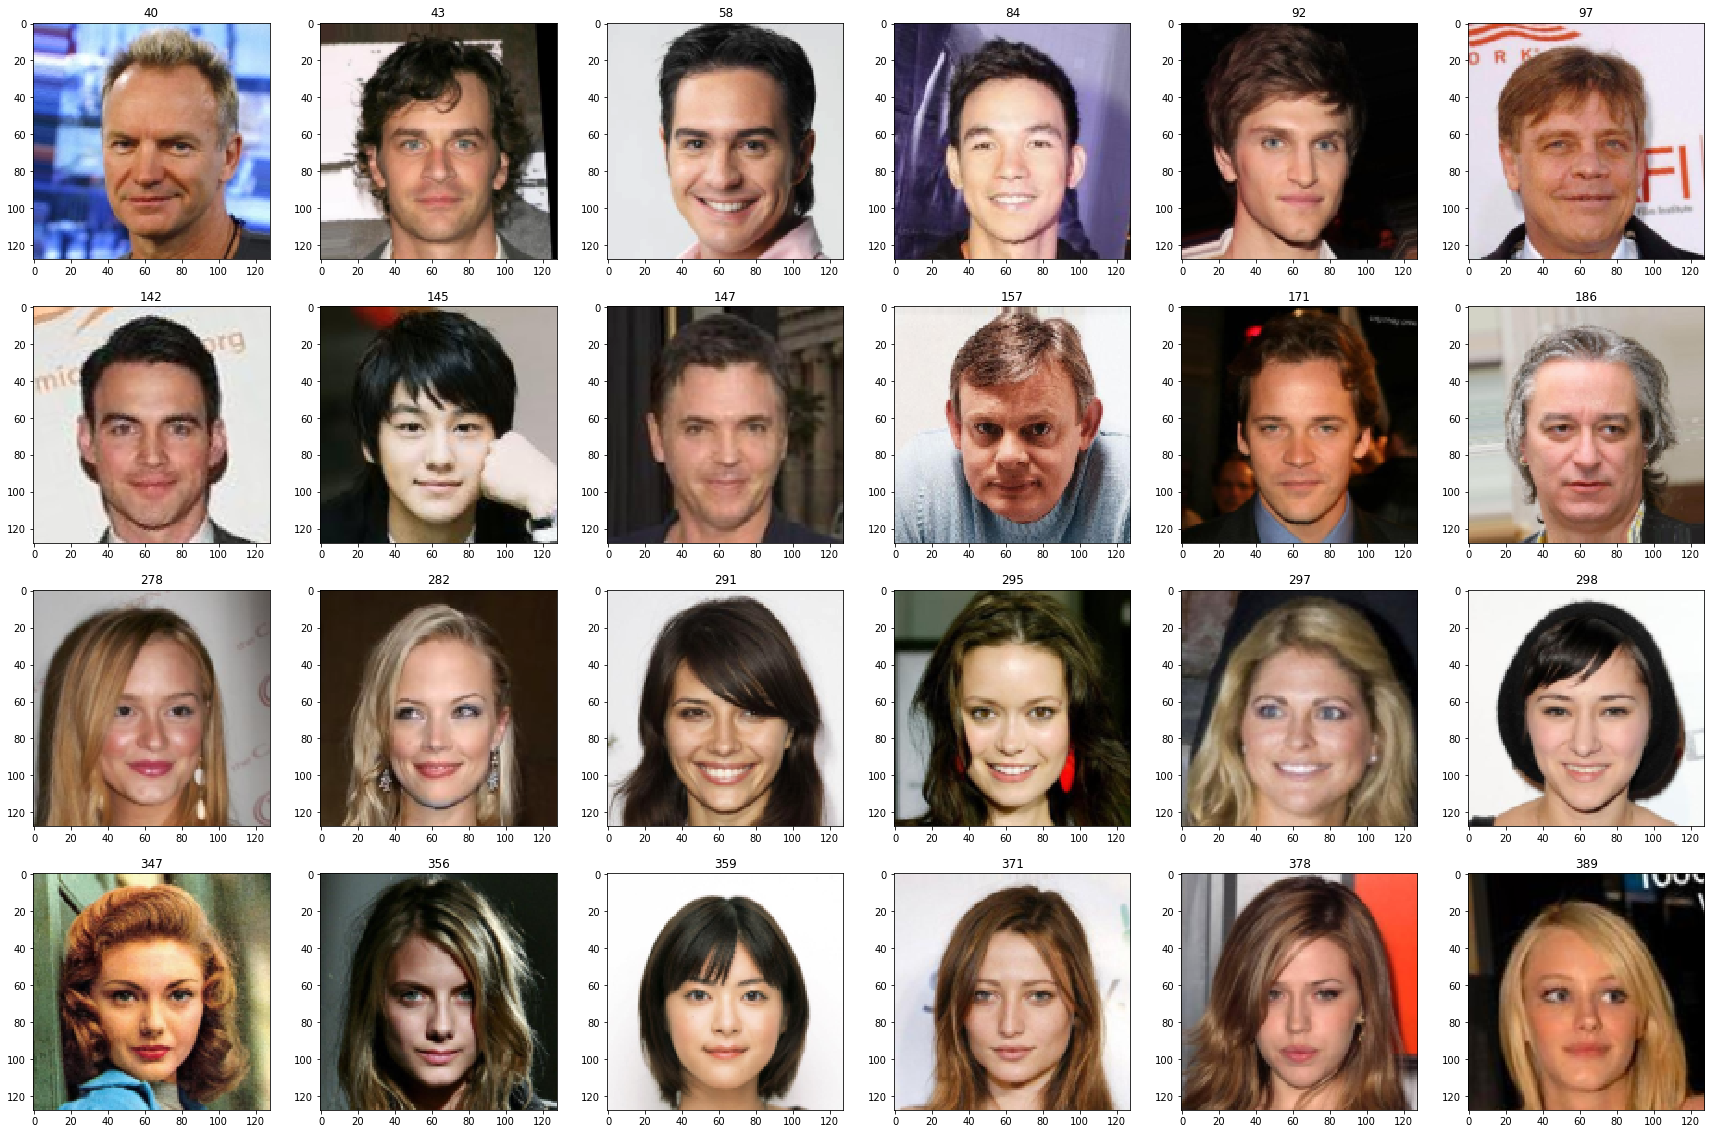

In [30]:
length = 4
width = 6

fig = plt.figure(figsize=(5*width, 5*length))

for i in range(length):
    for j in range(len(index_list[i])):
        ax = fig.add_subplot(length, width, i*width+j+1)
        index = index_list[i][j]
        image = testset[index][0]
        image = image_from_output(image.unsqueeze(0))[0]
        ax.imshow(image)
        ax.set_title(index)

In [35]:
index = 389
index = 359
if styleINdataset:
    latent_list = [
        latent[labels==0],
        latent[labels==1],
        latent[labels==2],
        latent[labels==3]
    ]
else:
    latent_list = latent
data, label = get_samples(netG, netE, testset, index, latent_list, classes, ref_label, ndim, image_type="pil", batch=32, device=device, conventional_E=False)
# data, label = get_samples(netG, netE, testset, index, latent[:num], classes, ref_label, ndim, image_type="pil", batch=32, device=device, conventional_E=False)

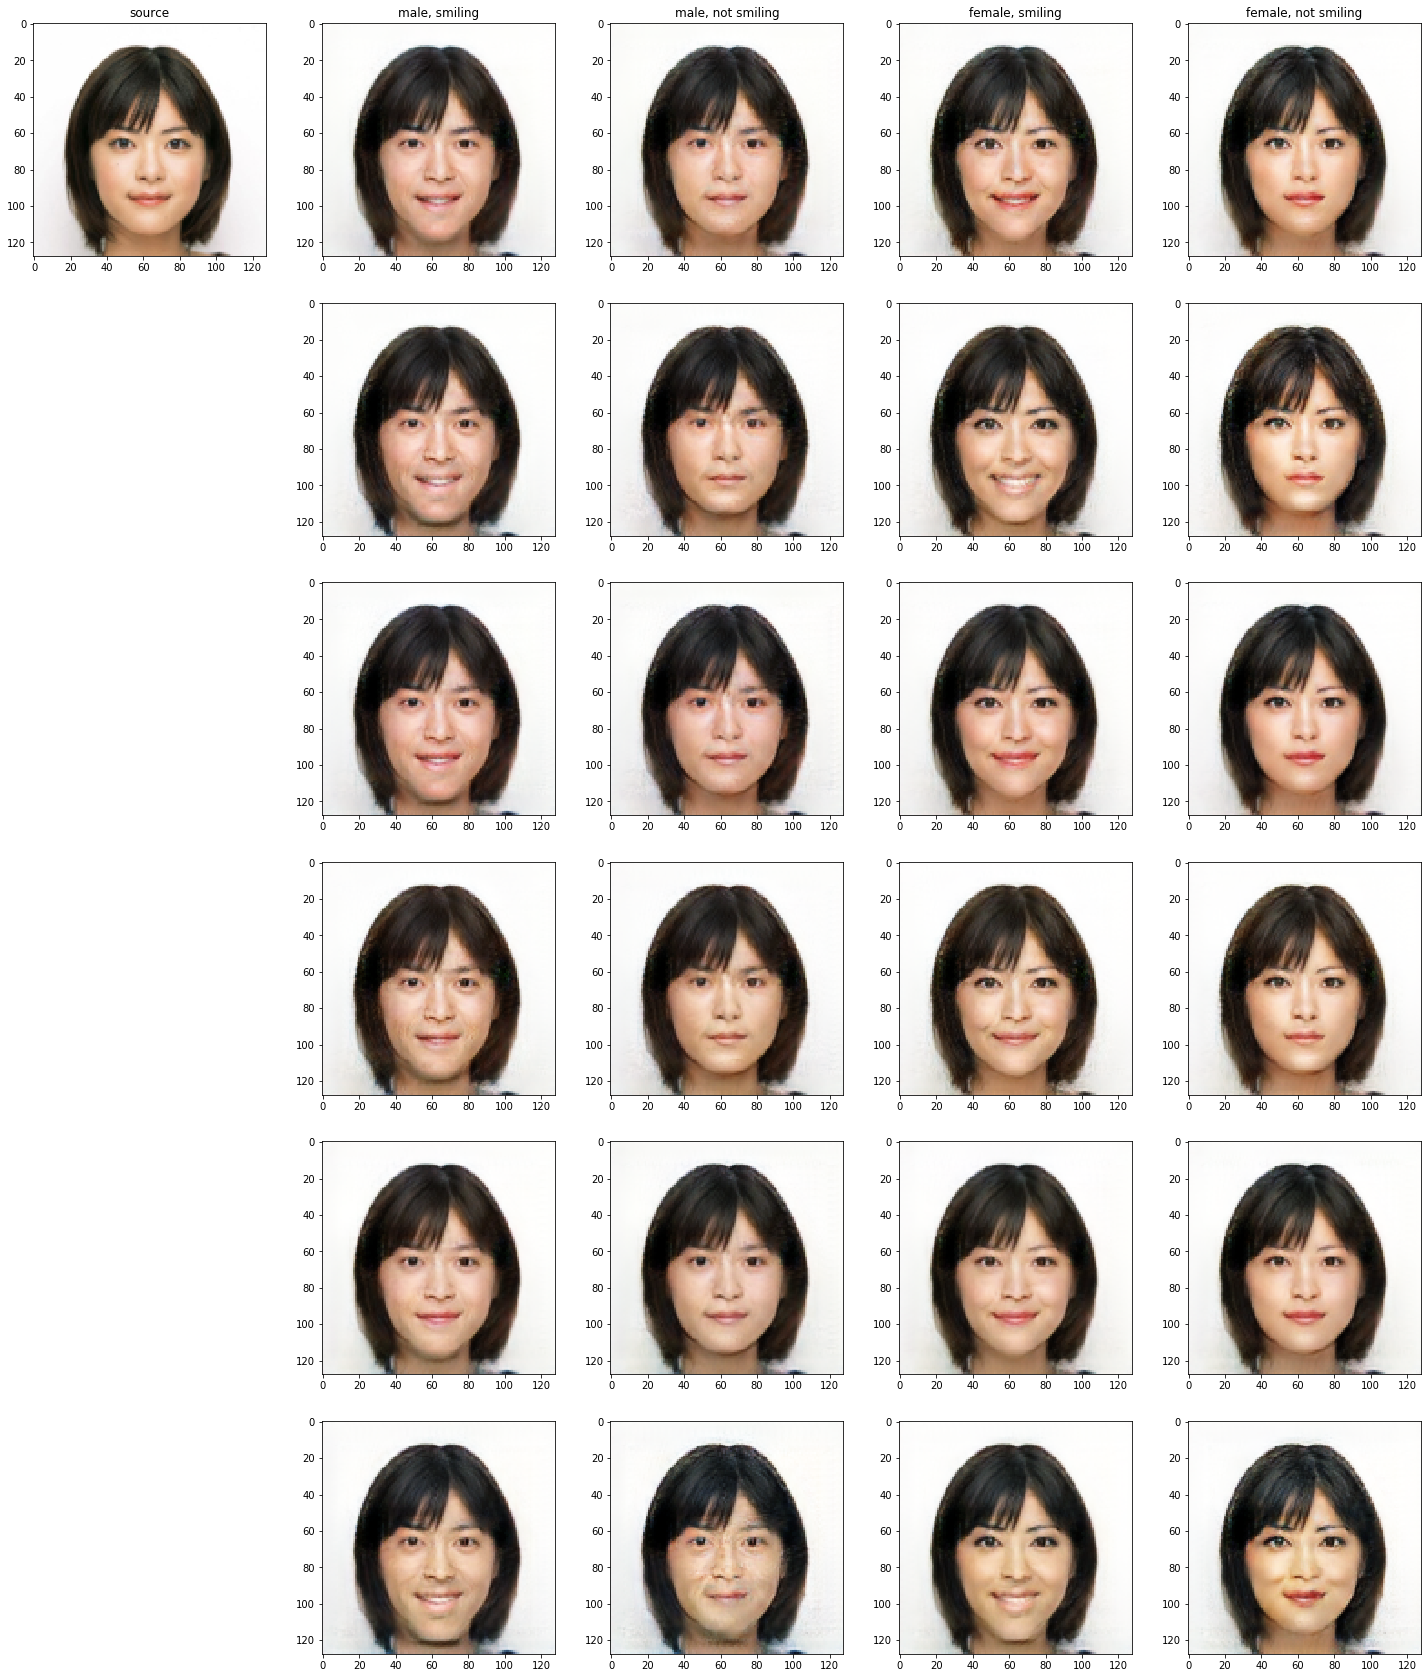

In [36]:
length = 6
images = data["target"]

width = len(classes)+1
fig = plt.figure(figsize=(5*width, 5*length))
np.random.seed(0)
a = np.random.choice(np.arange(num), length, False)
index = 1
ax = fig.add_subplot(length, width, index)
ax.imshow(data["source"])
ax.set_title("source")

for i in range(length):
    for j in classes:
        index = i*(len(classes)+1)+j+2
        ax = fig.add_subplot(length, width, index)
        ax.imshow(images[j][a[i]])
        if i == 0:
            ax.set_title(label_discription[j])

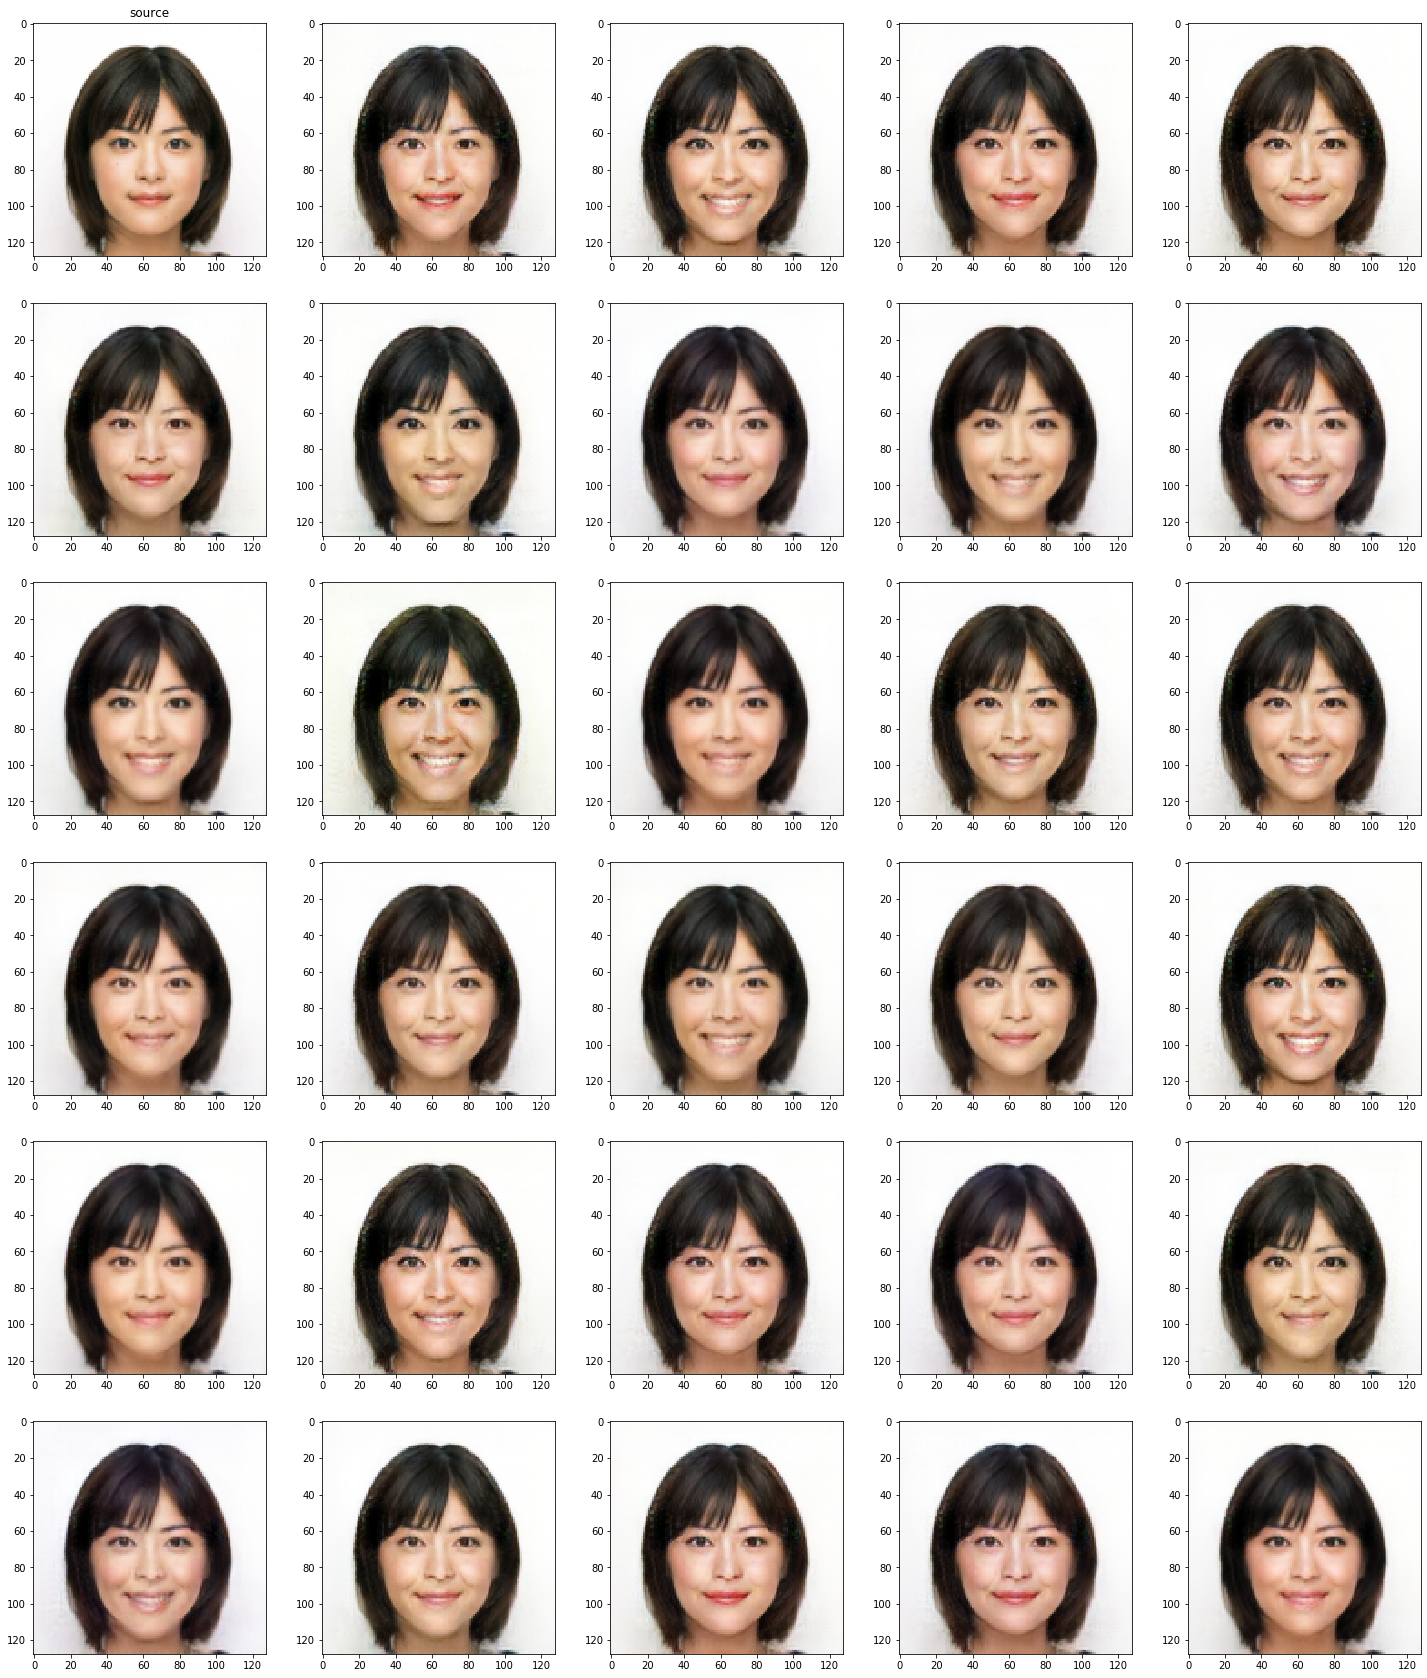

In [37]:
length = 6
width = 5
target_label = 2

images = data["target"][target_label]
np.random.seed(0)
a = np.random.choice(np.arange(num), length*width-1, False)
fig = plt.figure(figsize=(5*width, 5*length))
index = 1
ax = fig.add_subplot(length, width, index)
ax.imshow(data["source"])
ax.set_title("source")

for i in range(length*width-1):
    index = i+2
    ax = fig.add_subplot(length, width, index)
    ax.imshow(images[a[i]])

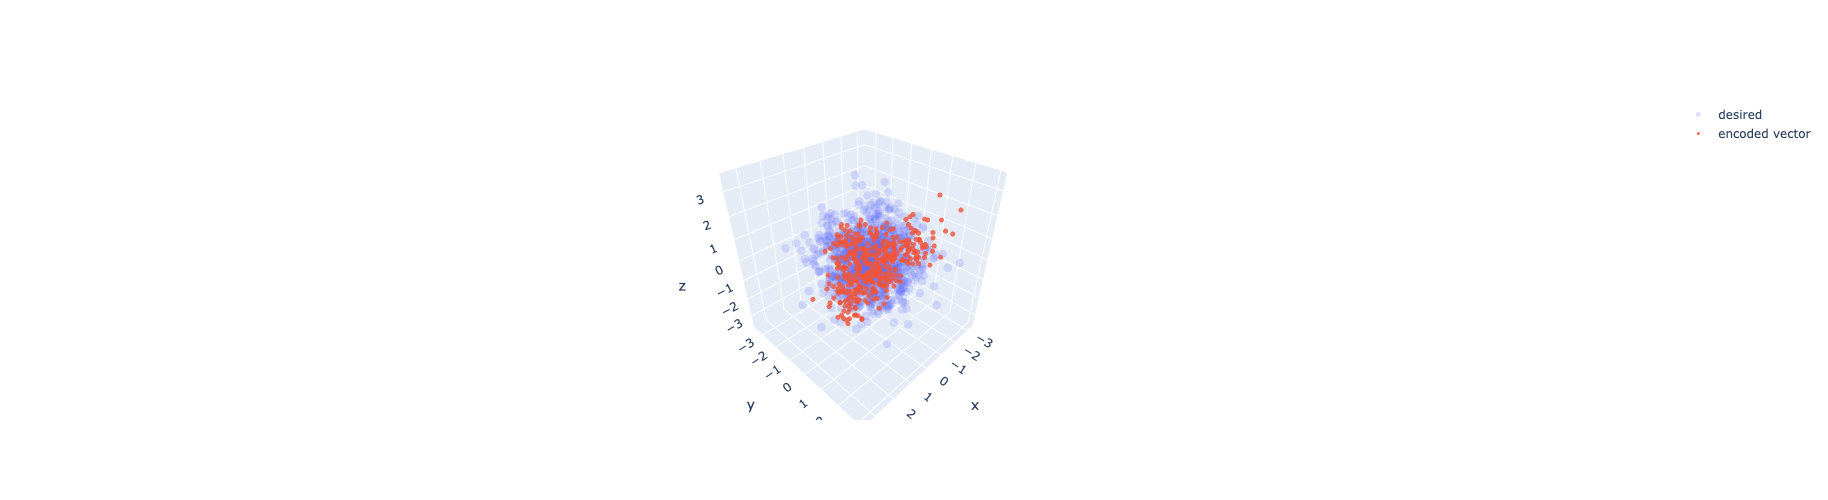

In [34]:
sample_num = 1000

trace = []
m = np.random.randn(1000, 3)
_x = m[:, 0] 
_y = m[:, 1]
_z = m[:, 2]
trace.append(go.Scatter3d(x=_x, y=_y, z=_z, mode="markers", name=f"desired", 
                          marker = dict(size=5, opacity=0.2)))

m = mu_list[:sample_num,2:]
_x = m[:, 0] 
_y = m[:, 1]
_z = m[:, 2]
trace.append(go.Scatter3d(x=_x, y=_y, z=_z, mode="markers", name=f"encoded vector", 
                          marker = dict(size=3, opacity=0.8)))


layout = go.Layout(width=500, height=500)    
data = trace
fig = dict(data=data, layout=layout)
iplot(fig)

## Encoder

### Restriction Distribution

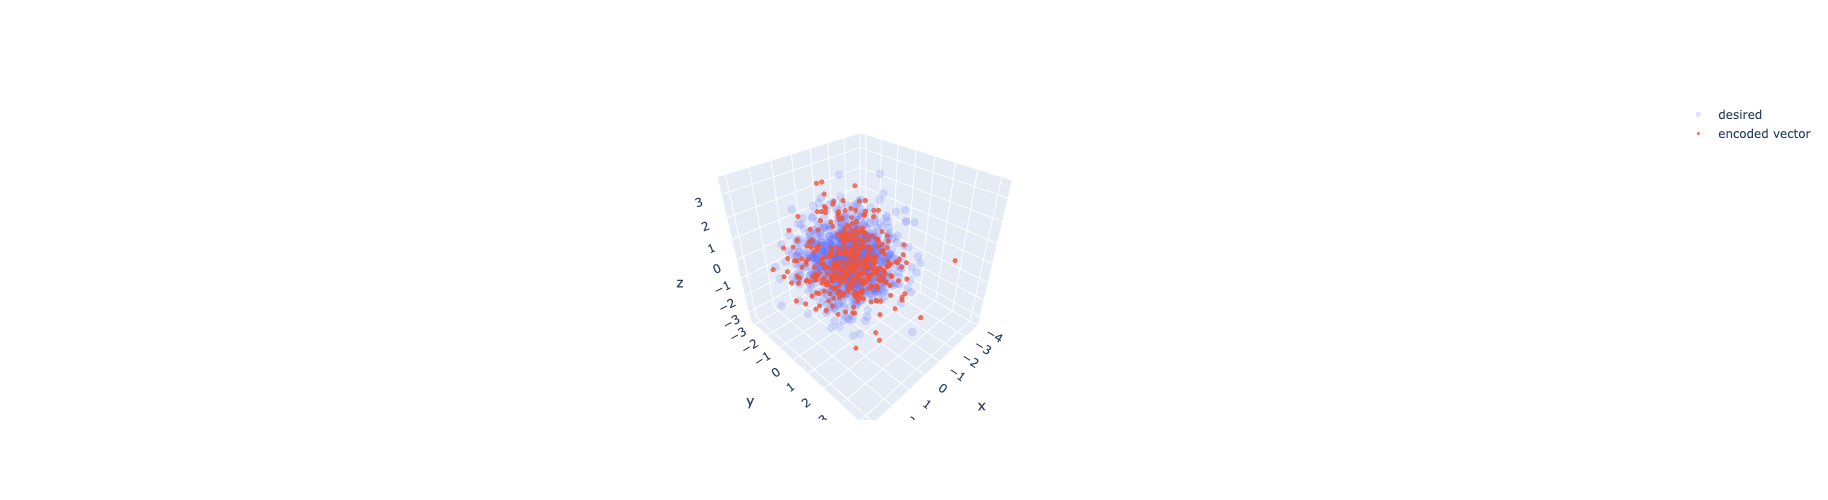

In [56]:
sample_num = 1000

trace = []
m = np.random.randn(1000, 3)
_x = m[:, 0] 
_y = m[:, 1]
_z = m[:, 2]
trace.append(go.Scatter3d(x=_x, y=_y, z=_z, mode="markers", name=f"desired", 
                          marker = dict(size=5, opacity=0.2)))

m = mu_list[:sample_num,0:]
_x = m[:, 0] 
_y = m[:, 1]
_z = m[:, 2]
trace.append(go.Scatter3d(x=_x, y=_y, z=_z, mode="markers", name=f"encoded vector", 
                          marker = dict(size=3, opacity=0.8)))


layout = go.Layout(width=500, height=500)    
data = trace
fig = dict(data=data, layout=layout)
iplot(fig)

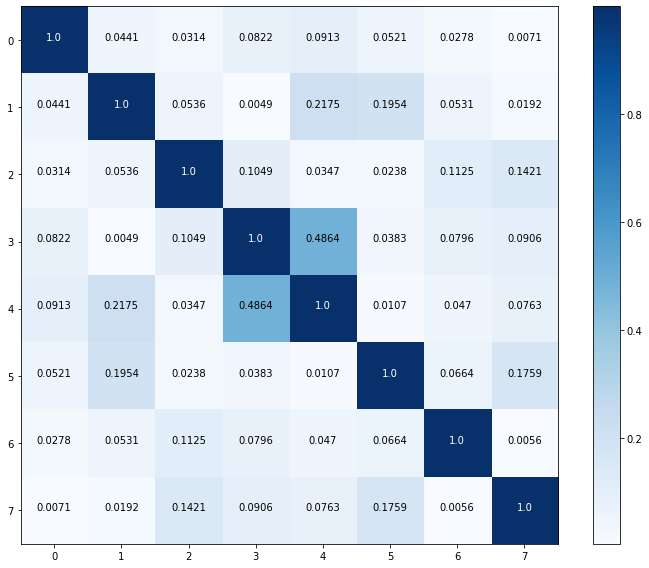

In [57]:
def plot_correlation_matrix(cm):
    cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()

    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, str(round(cm[i, j], 4)),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.show()
plot_correlation_matrix(np.abs(np.array(corrcoef(torch.tensor(mu_list.T)))))

Text(0.5, 1.0, 'plt histogram')

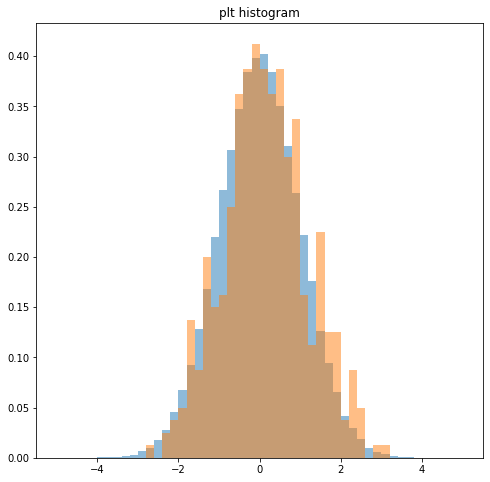

In [58]:
a = np.random.randn(100000, 8)
b = mu_list[:,:]
a = torch.tensor(a)
b = torch.tensor(b)

range_max = 5
bins = 50

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.hist(cuda2numpy(a[:,0]), bins=bins, range=(-range_max, range_max), density=True, alpha=0.5, label="desired");
ax.hist(cuda2numpy(b[:,3]), bins=bins, range=(-range_max, range_max), density=True, alpha=0.5, label="training")
ax.set_title("plt histogram")

### Distribution of encoded features

In [59]:
num = 10
batch_num = num
testset = FaceDataset(root, label_root, transform["test"], dataset_label, classes, data_type="test", train_num=each_train_num, val_num=0, test_num=num)

In [60]:
def get_style_score(a, b):
    c = a.reshape(1, -1, ndim)
    d = c.repeat(c.shape[1], 0)
    for i in range(d.shape[0]):
        d[i,:,:] = np.roll(d[i,:,:], i, axis=0)
        
    e = b.reshape(1, -1, ndim)
    f = e.repeat(e.shape[1], 0)
    g = np.sqrt(np.sum((f-d)**2, axis=2))
    
    i = g[0:1]
    j = np.mean(g[1:], axis=0, keepdims=True)
    k = i/j
    h = np.concatenate([i,j,k], axis=0).T
    all_score = pd.DataFrame(h, columns=["same style", "different style", "score"])
    mean_score = pd.DataFrame(np.mean(h, axis=0, keepdims=True), index=["mean"], columns=["same style", "different style", "score"])
    
    return all_score, mean_score

In [61]:
def get_distribution(sg, testset, device, classes, batch_num, each_num):
    dataloader = torch.utils.data.DataLoader(dataset=testset, batch_size=batch_num, shuffle=False)
    data = {}
    for cl in classes:
        data[cl] = {}
        for target in classes:
            data[cl][target] = {}
            
    for itr, x in enumerate(dataloader):
        cl = int(itr*batch_num/each_num)
        for target in classes:
            netE.eval()
            data_image = x[0].to(device)
            data_label = x[1].to(device)

            target_label = torch.ones(data_image.shape[0], dtype=torch.long, device="cpu")*target

            # random target
            if styleINdataset:
                target_random_image, [_,random_feature,_,_,_] = sg.G_transformation(target_label, data_image, True, data_image[list(np.arange(data_image.shape[0])[::-1])])
            else:
                target_random_image, random_feature = sg.G_transformation(target_label, data_image, False)

            # source target
            target_source_image, [_,source_feature,_,_,_] = sg.G_transformation(target_label, data_image, True, data_image)

            # get encoded features
            _, random_encoded, _, _, _ = sg.E(target_random_image)
            _, source_encoded, _, _, _ = sg.E(target_source_image)

            var_list = [
                data_image, 
                data_label,
                target_random_image,
                target_source_image,
                random_feature,
                source_feature,
                random_encoded,
                source_encoded,
            ]
            for var in var_list:
                for (key, value) in locals().items():
                    if id(value) == id(var):
                        var_name = key
                if itr*batch_num%each_num==0:
                    data[cl][target][var_name] = cuda2numpy(var)
                else:
                    data[cl][target][var_name] = np.concatenate([data[cl][target][var_name],cuda2numpy(var)], axis=0)
                    
    data["score"] = {}
    for source_label in classes:
        data["score"][source_label] = {}
        for target_label in classes:
            data["score"][source_label][target_label] = {}
            for feature_type in ["source", "random"]:
                data["score"][source_label][target_label][feature_type] = {}
                if feature_type=="source":
                    a = data[source_label][target_label]["source_feature"]
                    b = data[source_label][target_label]["source_encoded"]
                elif feature_type=="random":
                    a = data[source_label][target_label]["random_feature"]
                    b = data[source_label][target_label]["random_encoded"]

                all_score, mean_score = get_style_score(a, b)
                data["score"][source_label][target_label][feature_type]["all"] = all_score
                data["score"][source_label][target_label][feature_type]["mean"] = mean_score
    return data

In [62]:
data = get_distribution(sg, testset, device, classes, batch_num, num)

In [63]:
data["score"][0][1]["random"]["mean"]

same style  different style     score
mean    2.598073         4.141438  0.640777

In [64]:
data["score"][0][1]["source"]["mean"]

same style  different style     score
mean    1.684266         5.021795  0.324863

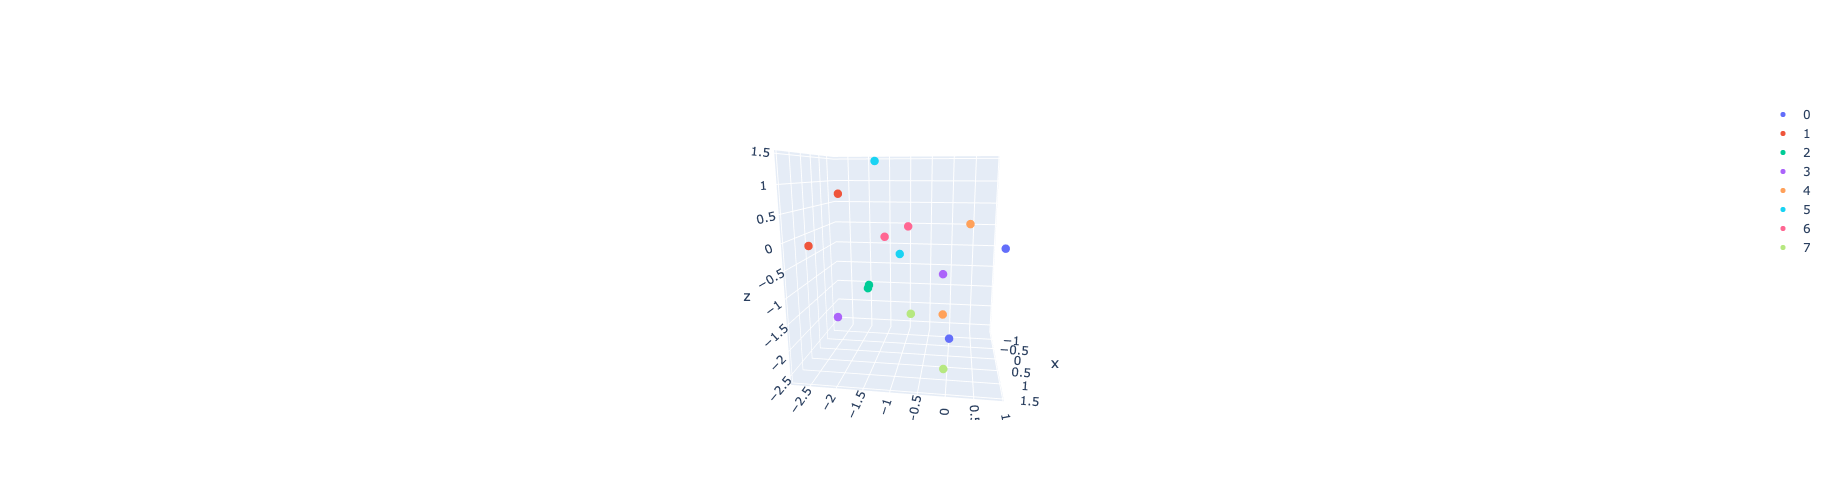

In [65]:
# target under source condition
data_num = 8
source_label = 1
target_label = 3

a = data[source_label][target_label]["random_feature"].reshape(-1,1,ndim)
b = data[source_label][target_label]["random_encoded"].reshape(-1,1,ndim)

trace = []
for i in range(data_num):
    m = np.concatenate([a[i], b[i]], axis=0)
    _x = m[:, 0] 
    _y = m[:, 1]
    _z = m[:, 2]
    trace.append(go.Scatter3d(x=_x, y=_y, z=_z, mode="markers", name=f"{i}", 
                              marker = dict(size=5)))
    
layout = go.Layout(width=500, height=500)    
fig = dict(data=trace, layout=layout)
iplot(fig)

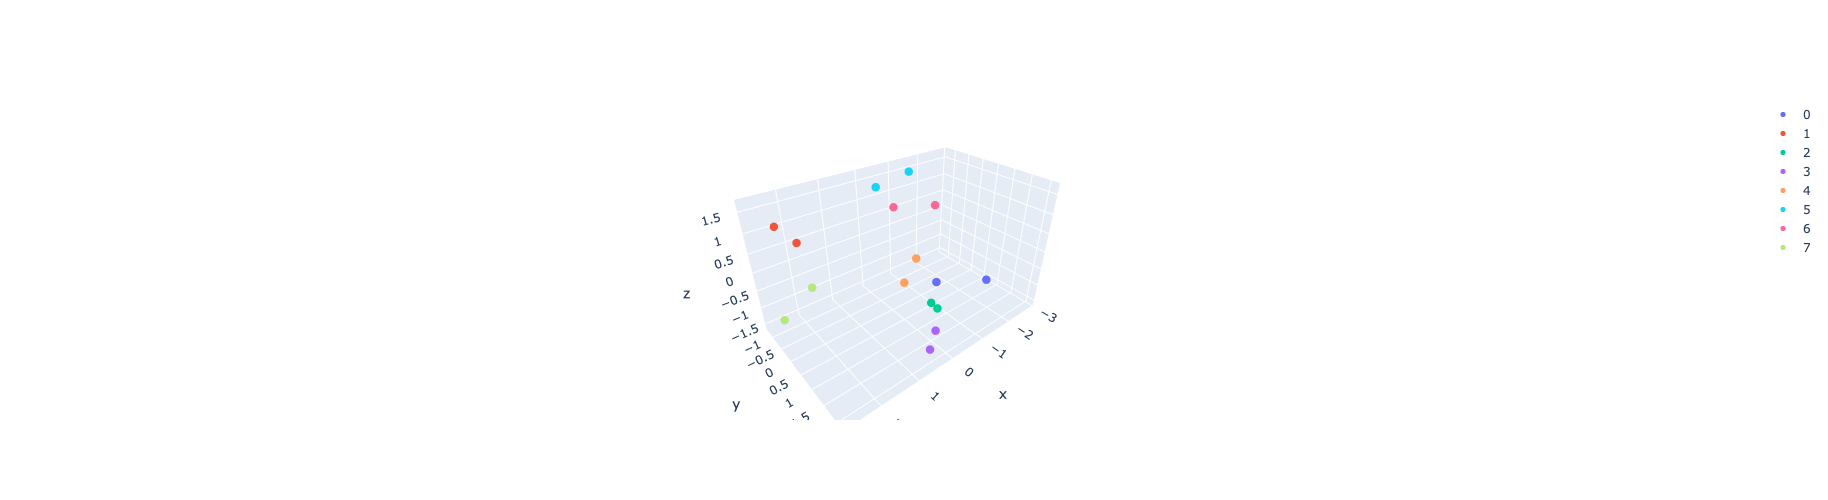

In [66]:
# target under source condition
data_num = 8
source_label = 0
target_label = 1

a = data[source_label][target_label]["source_feature"].reshape(-1,1,ndim)
b = data[source_label][target_label]["source_encoded"].reshape(-1,1,ndim)

trace = []
for i in range(data_num):
    m = np.concatenate([a[i], b[i]], axis=0)
    _x = m[:, 0] 
    _y = m[:, 1]
    _z = m[:, 2]
    trace.append(go.Scatter3d(x=_x, y=_y, z=_z, mode="markers", name=f"{i}", 
                              marker = dict(size=5)))
    
layout = go.Layout(width=500, height=500)    
fig = dict(data=trace, layout=layout)
iplot(fig)

## PRDC

### data

In [49]:
num = 1000
testset = FaceDataset(root, label_root, transform["test"], dataset_label, classes, data_type="test", train_num=each_train_num, val_num=0, test_num=num)

In [50]:
dataloader = torch.utils.data.DataLoader(dataset=testset, batch_size=128, shuffle=False)
for itr, data in enumerate(dataloader):
    netE.eval()
    data_image = data[0].to(device)
    data_label = data[1].to(device)
    
    if styleINdataset:
        _, mu, _, _, _ = netE(data_image)
    if itr==0:
        if styleINdataset:
            mu_list = cuda2cpu(mu)
        labels = cuda2cpu(data_label)
        samples = cuda2cpu(data_image)
    else:
        if styleINdataset:
            mu_list = np.concatenate([mu_list, cuda2cpu(mu)], axis=0)
        labels = np.concatenate([labels, cuda2cpu(data_label)], axis=0)
        samples = torch.cat([samples, cuda2cpu(data_image)], axis=0)
if styleINdataset:
    latent = mu_list
else:
    latent = np.random.randn(num, ndim)

In [51]:
index = len(testset) - 11
# index = len(testset)//len(classes) - 16
if styleINdataset:
    latent_list = [latent[labels==0],
                   latent[labels==1],
                   latent[labels==2],
                   latent[labels==3]]
else:
    latent_list = latent
data, label = get_samples(netG, netE, testset, index, latent_list, classes, ref_label, ndim, image_type="tensor", batch=32, device=device, conventional_E=False)

### evaluation

In [52]:
fe_list = ["vgg-initialization", 
           "vgg-ImageNet", 
           "vgg-CelebA"]

In [53]:
ge = GAN_evaluation(fe_list[0], device, classes, [target_label])
metrics = ge.get_prdc(samples[labels==target_label], data["target"][target_label], preprocess=True)
metrics

Num real: 1000 Num fake: 1000


{'precision': 1.0, 'recall': 0.0, 'density': 0.5396, 'coverage': 0.012}

In [54]:
ge = GAN_evaluation(fe_list[1], device, classes, [target_label])
metrics = ge.get_prdc(samples[labels==target_label], data["target"][target_label], preprocess=True)
metrics

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /opt/.cache/torch/checkpoints/vgg19_bn-c79401a0.pth
4.3%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

11.7%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

19.2%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_l

Num real: 1000 Num fake: 1000


{'precision': 1.0, 'recall': 0.0, 'density': 1.7424, 'coverage': 0.078}

In [55]:
ge = GAN_evaluation(fe_list[2], device, classes, [target_label])
metrics = ge.get_prdc(samples[labels==target_label], data["target"][target_label], preprocess=True)
metrics

Num real: 1000 Num fake: 1000


{'precision': 0.996,
 'recall': 0.612,
 'density': 1.0166000000000002,
 'coverage': 0.541}

In [41]:
ge = GAN_evaluation(fe_list[2], device, classes, [target_label])
metrics = ge.get_prdc(samples[labels==target_label], data["target"][target_label], preprocess=True)
metrics

Num real: 1000 Num fake: 1000


{'precision': 0.997, 'recall': 0.315, 'density': 1.1084, 'coverage': 0.291}

In [43]:
sample_num = 100
init = True

if init:
    GAN_eval = evaluation_init(fe_list, classes, metrics)
    start = 0
else:
    start = len(GAN_eval[fe_list[0]][0][0]["coverage"])
    
for i in range(sample_num):
    clear_output(wait=True)
    print(i)
    for source_label in classes:
        index = source_label*num + (start+i)
        data, label = get_samples(netG, netE, testset, index, latent_list, classes, ref_label, ndim, image_type="tensor", batch=32, device=device, conventional_E=False)
        for target_label in classes:
            for fe in fe_list:
                ge = GAN_evaluation(fe, device, classes, [target_label])
                metrics = ge.get_prdc(samples[labels==target_label], data["target"][target_label], preprocess=True)
                for metric in metrics.keys():
                    GAN_eval[fe][source_label][target_label][metric].append(metrics[metric])

99
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num rea

In [44]:
save = False
path = f"../data/results/05/05_GAN_evaluation_{model_type}_{attention_mode}_attention{lbd['attention']}_consisreg{lbd['consis_reg']}.pkl"

if save:
    pickle_save(GAN_eval, path)